# Kardiomiopatia Przerostowa

In [1]:
import cv2
import skimage.io as io
import matplotlib.pyplot as plt
import src.show as show

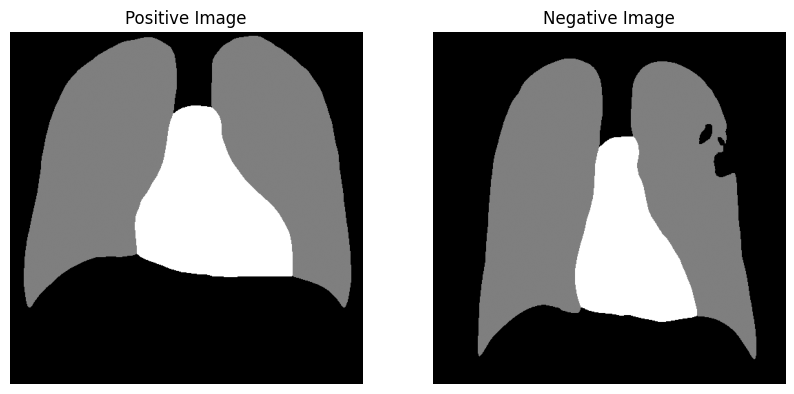

In [2]:
positive = io.imread("data\\11KB.png")
negative = io.imread("data\\17MB.png")

show.show_together(positive, "Positive Image", negative, "Negative Image")

# Jak wygląda diagnostyka teraz
Standardem diagnostyki kardiomiopatii przerostowej na podstawie CT klatki piersiowej jest pomiar najdłuższej linii serca i płuc. Następnie dzieli się je przez siebie — jeżeli otrzymany wynik jest większy niż 0,5, uznaje się, że pacjent cierpi na kardiomiopatię przerostową (przypadek pozytywny).


In [3]:
import src.standard as std

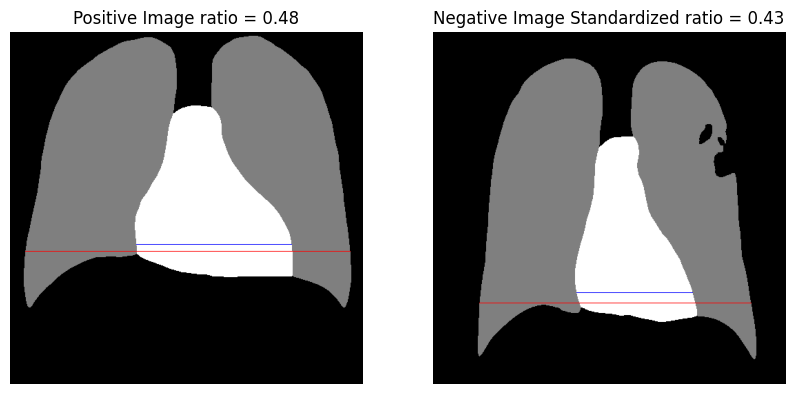

In [4]:
positive_result = std.lines_ratio(positive)
negative_result = std.lines_ratio(negative)

show.show_together(positive_result["img"], f"Positive Image ratio = {positive_result['ratio']}", 
                   negative_result["img"], f"Negative Image Standardized ratio = {negative_result['ratio']}")

## Skuteczność metody
Na podstawie naszych danych ustaliliśmy, że metoda ta poprawnie rozpoznaje mniej niż 50% przypadków kardiomiopatii przerostowej.

# KN AI MED AGH - czym się właściwie zajmujemy 
Naszym celem jest właśnie poprawienie skuteczności diagnostyki, na przykład kardiomiopatii przerostowej. Obecnie zajmujemy się projektem, w którym, z wykorzystaniem klasycznych metod uczenia maszynowego, tworzymy rozwiązanie problemu rozpoznania kardiomiopatii przerostowej ze zdjęć tomografii komputerowej.

W ramach tego projektu każda grupa stara się opracować zbiór cech opisujących serce, które pomogą w treningu modelu.
 

### Mapy odelgłości pixeli od środka

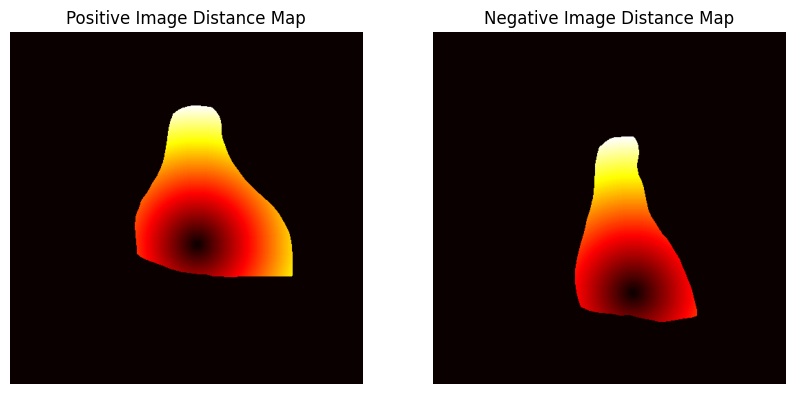

In [5]:
import src.features as feat
positive_map = feat.distance_map_center(positive)
negative_map = feat.distance_map_center(negative)

show.show_together(positive_map, "Positive Image Distance Map",
                   negative_map, "Negative Image Distance Map", map = 'hot')





Wyniki dla: 11KB.png
displacement: 106
bottom_asymmetry_ratio: nan
left_edge_curvature: 0.05356161715299434
center_x: 287
center_y: 257


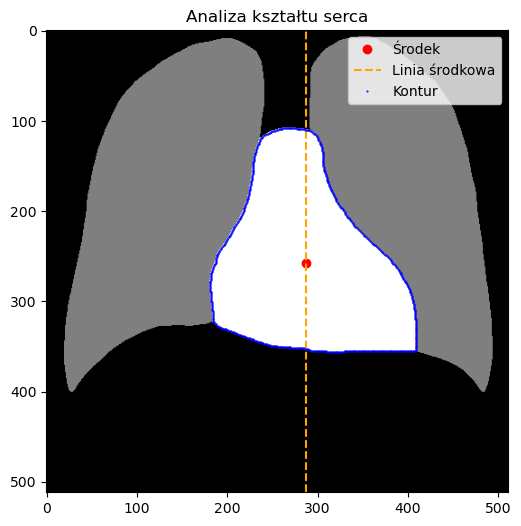


Wyniki dla: 17MB.png
displacement: 76
bottom_asymmetry_ratio: 0.5108728030980042
left_edge_curvature: 0.0660820423442343
center_x: 282
center_y: 312


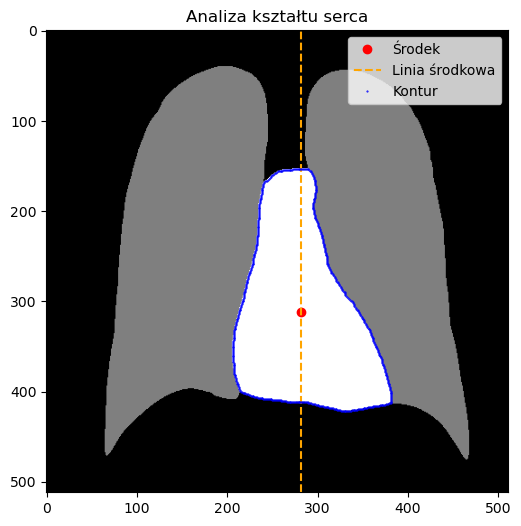

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d


def preprocess_mask(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    heart_mask = (mask[:, :, 0] == 255).astype(np.uint8) if len(mask.shape) == 3 else (mask == 255).astype(np.uint8)
    return heart_mask


def get_heart_contour(heart_mask):
    contours, _ = cv2.findContours(heart_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    return max(contours, key=cv2.contourArea)


def compute_center_of_mass(mask):
    M = cv2.moments(mask)
    if M["m00"] == 0:
        return mask.shape[1] // 2, mask.shape[0] // 2
    cx = int(M["m10"] / M["m00"])
    cy = int(M["m01"] / M["m00"])
    return cx, cy


def max_left_displacement(contour, center_x, center_y):
    left_points = [pt[0][0] for pt in contour if pt[0][0] < center_x and pt[0][1] > center_y]
    if not left_points:
        return 0
    leftmost = min(left_points)
    return center_x - leftmost


def bottom_asymmetry_ratio(heart_mask, center_x):
    h = heart_mask.shape[0]
    bottom = heart_mask[int(0.75 * h):, :]
    left = np.sum(bottom[:, :center_x])
    right = np.sum(bottom[:, center_x:])
    return left / right if right != 0 else np.nan


def left_edge_curvature(contour, center_x, center_y):
    left_edge = np.array([pt[0] for pt in contour if pt[0][0] < center_x and pt[0][1] > center_y])
    if len(left_edge) < 5:
        return np.nan

    left_edge = left_edge[np.argsort(left_edge[:, 1])]  # sortuj po y (wysokości)
    x = left_edge[:, 0].astype(float)
    y = left_edge[:, 1].astype(float)

    x_smooth = gaussian_filter1d(x, sigma=2)
    dx = np.gradient(x_smooth)
    ddx = np.gradient(dx)

    curvature = np.abs(ddx) / (1 + dx**2)**1.5
    return np.nanmean(curvature)


def analyze_heart_shape(mask_path):
    heart_mask = preprocess_mask(mask_path)
    contour = get_heart_contour(heart_mask)
    center_x, center_y = compute_center_of_mass(heart_mask)

    displacement = max_left_displacement(contour, center_x, center_y)
    bottom_ratio = bottom_asymmetry_ratio(heart_mask, center_x)
    curvature = left_edge_curvature(contour, center_x, center_y)

    return {
        "displacement": displacement,   #Największa pozioma odległość od lewej dolnej krawędzi serca do pionowej linii środka (center_x)
        "bottom_asymmetry_ratio": bottom_ratio, #Stosunek powierzchni lewej dolnej części serca do prawej (tylko dolne 25% obrazu)
        "left_edge_curvature": curvature,   #Średnia krzywizna dolnej lewej krawędzi konturu serca
        "center_x": center_x,   #Współrzędna X środka serca
        "center_y": center_y    #Współrzędna Y środka serca
    }


def batch_analyze(folder_path="wizualizacje", output_csv="koniuszek_pomiary.csv"):
    results = []
    for fname in os.listdir(folder_path):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            fpath = os.path.join(folder_path, fname)
            res = analyze_heart_shape(fpath)
            res['filename'] = fname
            results.append(res)

    df = pd.DataFrame(results)
    df.to_csv(output_csv, index=False)
    print(f"Zapisano wyniki do {output_csv}")


def visualize_analysis(mask_path, results):
    img = cv2.imread(mask_path)
    heart_mask = preprocess_mask(mask_path)
    contour = get_heart_contour(heart_mask)

    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap='gray')
    plt.plot(results["center_x"], results["center_y"], 'ro', label="Środek")
    plt.axvline(x=results["center_x"], color='orange', linestyle='--', label="Linia środkowa")
    plt.plot([pt[0][0] for pt in contour], [pt[0][1] for pt in contour], 'b.', markersize=1, label="Kontur")
    plt.title("Analiza kształtu serca")
    plt.legend()
    plt.show()


# Przykład użycia
if __name__ == "__main__":
    folder = "data"
    filenames = ["11KB.png", "17MB.png"]

    for fname in filenames:
        path = os.path.join(folder, fname)
        results = analyze_heart_shape(path)
        
        print(f"\nWyniki dla: {fname}")
        for key, val in results.items():
            print(f"{key}: {val}")
        
        visualize_analysis(path, results)

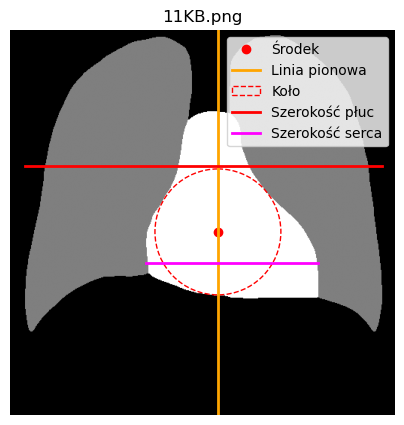

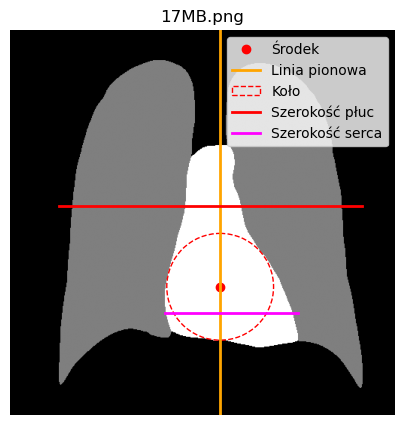

In [9]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.graph import route_through_array
from scipy.ndimage import distance_transform_edt

def analyze_heart_center(mask):
    heart_mask = (mask == 255).astype(np.uint8)
    lung_mask = (mask == 128).astype(np.uint8)

    dist_transform = distance_transform_edt(heart_mask)
    max_dist = np.max(dist_transform)
    center_coords = np.unravel_index(np.argmax(dist_transform), dist_transform.shape)
    center_x = center_coords[1]

    start_points = np.argwhere(heart_mask[0, :] > 0)
    end_points = np.argwhere(heart_mask[-1, :] > 0)
    min_path = None
    min_cost = np.inf

    for sp in start_points:
        for ep in end_points:
            start = (0, sp[0])
            end = (heart_mask.shape[0] - 1, ep[0])
            try:
                path, cost = route_through_array(-dist_transform, start, end, fully_connected=True)
                if cost < min_cost:
                    min_cost = cost
                    min_path = path
            except:
                continue

    path = np.array(min_path) if min_path is not None else np.array([])

    heart_columns = np.any(heart_mask, axis=0)
    heart_indices = np.where(heart_columns)[0]
    heart_width = float(np.sum(heart_columns))
    heart_left = heart_indices.min() if heart_indices.size > 0 else 0
    heart_right = heart_indices.max() if heart_indices.size > 0 else 0

    lung_mask_rgb = cv2.inRange(mask, 127, 129)
    lung_points = np.argwhere(lung_mask_rgb > 0)
    if lung_points.size > 0:
        x_coords = lung_points[:, 1]
        lungs_width = float(x_coords.max() - x_coords.min())
        diaphragm_y = int(np.mean(lung_points[:, 0]))
    else:
        lungs_width = 0.0
        diaphragm_y = mask.shape[0] - 1

    left_area = np.sum(heart_mask[:, :center_x])
    right_area = np.sum(heart_mask[:, center_x:])
    side_ratio = left_area / right_area if right_area > 0 else np.nan

    lower_heart = heart_mask[center_coords[0]+int(max_dist):, :]
    left_lower_pixels = np.sum(lower_heart[:, :center_x])
    right_lower_pixels = np.sum(lower_heart[:, center_x:])
    lower_ratio = left_lower_pixels / right_lower_pixels if right_lower_pixels > 0 else np.nan

    return {
        "center_y": center_coords[0],
        "center_x": center_x,
        "radius": max_dist,
        "path": path,
        "heart_width": heart_width,
        "lungs_width": lungs_width,
        "diaphragm_y": diaphragm_y,
        "left_area": left_area,
        "right_area": right_area,
        "side_ratio": side_ratio,
        "left_lower_pixels": left_lower_pixels,
        "right_lower_pixels": right_lower_pixels,
        "lower_ratio": lower_ratio,
        "heart_left": heart_left,
        "heart_right": heart_right
    }

def show_analysis(image_path):
    mask = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    data = analyze_heart_center(mask)

    plt.figure(figsize=(5, 5))
    plt.imshow(mask, cmap='gray')

    if data["path"].size > 0:
        plt.plot(data["path"][:, 1], data["path"][:, 0], 'orange', label="Dijkstra")

    plt.plot(data["center_x"], data["center_y"], 'ro', label="Środek")
    plt.axvline(x=data["center_x"], color='orange', linestyle='-', linewidth=2, label="Linia pionowa")
    plt.gca().add_patch(plt.Circle(
        (data["center_x"], data["center_y"]),
        data["radius"], color='r', fill=False, linestyle='--', label="Koło"
    ))

    lung_mask_rgb = cv2.inRange(mask, 127, 129)
    lung_points = np.argwhere(lung_mask_rgb > 0)
    if lung_points.size > 0:
        x_coords = lung_points[:, 1]
        y_mean = int(np.mean(lung_points[:, 0]))
        x1, x2 = x_coords.min(), x_coords.max()
        plt.plot([x1, x2], [y_mean, y_mean], color='red', linewidth=2, label="Szerokość płuc")

    heart_y = int(data["center_y"] + data["radius"] / 2)
    plt.plot([data["heart_left"], data["heart_right"]], [heart_y, heart_y], color='magenta', linewidth=2, label="Szerokość serca")

    plt.axis('off')
    plt.legend()
    plt.title(os.path.basename(image_path))
    plt.show()

if __name__ == "__main__":
    folder_path = "data"
    filenames = [r"11KB.png", r"17MB.png"]
    for filename in filenames:
        image_path = os.path.join(folder_path, filename)
        if os.path.exists(image_path):
            show_analysis(image_path)
        else:
            print(f"Plik nie znaleziony: {filename}")